In [542]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import gamma

In [543]:
def deriv_SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def deriv_SEIR(y, t, N, beta,sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# SIR: Predict S, I, R given S0, I0, R0, beta, gamma
def SIR_predict(y0, t, beta, gamma):
    ret = odeint(deriv_SIR, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return S, I, R

# SIR: Used to find I0, beta, gamma via curve_fit
def SIR_first(t, I0, beta, gamma):
    S0 = N - I0 - R0
    y0 = np.array([S0, I0, R0])
    ret = odeint(deriv_SIR, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return I

# SEIR: Predict S, E, I, R given S0, I0, R0, beta, gamma
def SEIR_predict(y0, t, beta, sigma, gamma):
    ret = odeint(deriv_SEIR, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = ret.T
    return S, E, I, R

# Used to find beta, gamma via curve_fit
def SEIR(t, beta, sigma, gamma):
    ret = odeint(deriv_SEIR, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = ret.T
    return I

def R_0(beta, gamma):
    return beta / gamma

# # Used to find beta, gamma via curve_fit
# def SIR(t, beta, gamma):
#     ret = odeint(deriv_SIR, y0, t, args=(N, beta, gamma))
#     S, I, R = ret.T
#     return I

In [544]:
def fit_SIR_first(tmin, tmax, y0):
    print('Start: ', xdata[tmin])
    print('End: ', xdata[tmax])
    t = np.arange(tmin, tmax)
    
    # This part is to predict R0 and I0 at the beginning of the epidemic
    p0 = [400, 0.8, 1./10]
    popt,_ = curve_fit(SIR_first, t, np.array(I[tmin:tmax]), p0) # the outputs are I0, beta, gamma fitted
    print('Rt = ', R_0(popt[1], popt[2]))
    R_0_list.append(R_0(popt[1], popt[2]))
    
    # This part is to estimate s, i, r at the end of the time lapse
    I0, R0 = int(popt[0]), R[tmax]
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    s, i, r = SIR_predict(y0, t, popt[1], popt[2])
    i_list.append(i)
    return s, i, r

def fit_SEIR(tmin, tmax, y0, append = True):
    if append:
        print('Start: ', xdata[tmin])
        print('End: ', xdata[tmax])
    t = np.arange(tmin, tmax)
    
    # This part is to predict R0
    popt, _ = curve_fit(SEIR, t, np.array(I[tmin:tmax]), bounds = (0, [3., 3., 1.]))
    if append:
        R_0_list.append(R_0(popt[0], popt[2]))
        print('Rt = ', R_0(popt[0], popt[2]))
        
    # This part is to estimate s, e, i, r at the end of the time lapse
    s, e, i, r = SEIR_predict(y0, t, popt[0], popt[1], popt[2])
    if append:
        i_list.append(i)
    return s, e, i, r

In [545]:
# R_t functions based on known parameters

def generation_time(x):
    return gamma.pdf(x, 1.88, scale=1./0.26)

def R_t(I, t):
    num = I[t]
    den = 0
    for s in range(0,t+1):
        den += I[t-s] * generation_time(s)
    return num/den

In [546]:
def normalized(x, factor = 1, normalized = True):
    if normalized:
        return (x-min(x))/(max(x)-min(x))*factor
    else:
        return x

# Percentual variation
def percentual_change(x, media = 7):
    perc = [0]
    day = [0]
    for i in range(0,len(x)-1, media):
        var1 = x[i:i+media].mean()
        var2 = x[i+media:i+media*2].mean()
        ch = (var2 - var1)
        perc.append(ch)
        day.append(int(i+media/2))
    return perc, day

Dataframe riassuntivo per la Lombardia (in questo caso)

In [547]:
df_covid = pd.read_csv('data/dpc-covid19-ita-andamento-nazionale.csv', parse_dates = ['data'])
#df_covid = df_covid[df_covid['denominazione_regione'] == 'Lombardia']
df_covid = df_covid[df_covid['data'] < '2020-12-29']
df_covid['data'] = pd.to_datetime(df_covid['data']).dt.date
#df_covid = df_covid.drop(columns = ['casi_da_sospetto_diagnostico', 'casi_da_screening', 'tamponi', 'casi_testati', 'note', 'ingressi_terapia_intensiva', 
#                                   'note_test', 'note_casi', 'totale_positivi_test_molecolare', 'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
#                                   'tamponi_test_antigenico_rapido', 'ricoverati_con_sintomi', 'terapia_intensiva', 'stato', 'isolamento_domiciliare',
#                                   'totale_ospedalizzati', 'codice_regione', 'denominazione_regione', 'lat', 'long', 'codice_nuts_1' , 'codice_nuts_2'])

df_covid['recovered_death'] = df_covid['dimessi_guariti'] + df_covid['deceduti']
df_covid = df_covid.reset_index()
xdata = df_covid['data']
print(f'Start: {xdata[0]}')
print(f'End: {xdata[len(xdata)-1]}')
df_covid.head(10)

Start: 2020-02-24
End: 2020-12-28


,index,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,...,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,recovered_death
0,0,2020-02-24,ITA,101,26,127,94,221,0,221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,1,2020-02-25,ITA,114,35,150,162,311,90,93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
2,2,2020-02-26,ITA,128,36,164,221,385,74,78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
3,3,2020-02-27,ITA,248,56,304,284,588,203,250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
4,4,2020-02-28,ITA,345,64,409,412,821,233,238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67
5,5,2020-02-29,ITA,401,105,506,543,1049,228,240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79
6,6,2020-03-01,ITA,639,140,779,798,1577,528,566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117
7,7,2020-03-02,ITA,742,166,908,927,1835,258,342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201
8,8,2020-03-03,ITA,1034,229,1263,1000,2263,428,466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239
9,9,2020-03-04,ITA,1346,295,1641,1065,2706,443,587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383


In [548]:
I = df_covid['totale_positivi']
R = df_covid['recovered_death']
N = 59550000

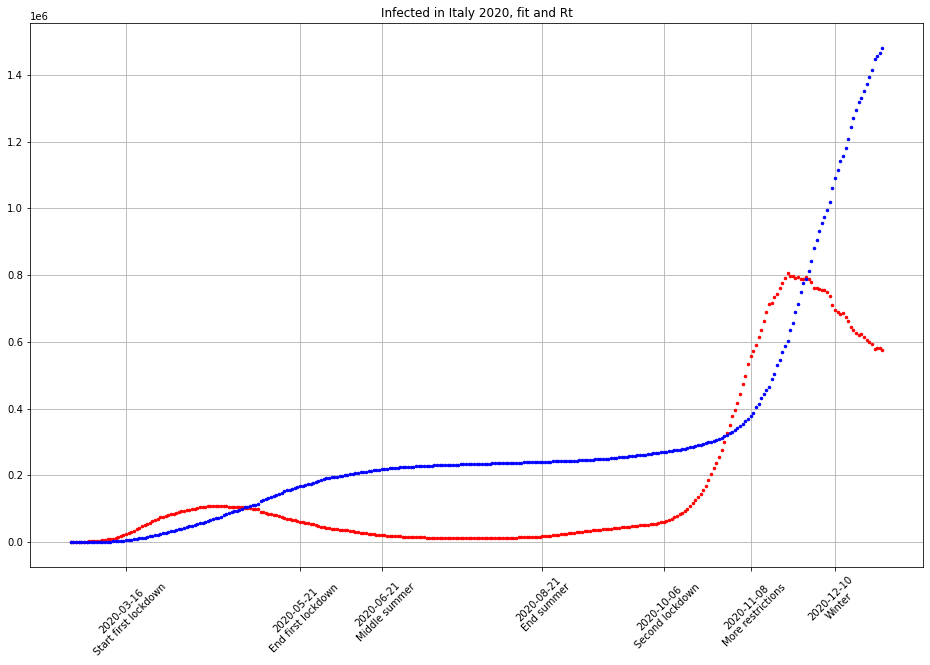

In [316]:
plt.figure(figsize=(16, 10))
plt.plot(xdata, I, 'r.', markersize=5)
plt.plot(xdata, R, 'b.', markersize=5)
plt.title('Infected in Italy 2020, fit and Rt')
plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

# Fit and R_t 

In [9]:
t_list = [[0,21], [21, 87], [87, 118], [118, 179], [179, 225], [225, 258], [258, 290],
         [290, 300]]

R_0_list = []
i_list = []
s, e, i, r = np.array([0]), np.array([0]), np.array([0]), np.array([0])

In [10]:
tmin, tmax = t_list[0][0], t_list[0][1] # Time interval
I0, R0 = I[tmin], R[tmin] # Known data
S0 = N - I0 - R0
y0 = S0, I0, R0
s, i, r = fit_SIR_first(tmin, tmax, y0) # Calculation of R_0 via SIR model
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0, append=False) # Estimation of s, e, i, r

tmin, tmax = t_list[1][0], t_list[1][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

tmin, tmax =t_list[2][0], t_list[2][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

tmin, tmax =t_list[3][0], t_list[3][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

tmin, tmax =t_list[4][0], t_list[4][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

tmin, tmax =t_list[5][0], t_list[5][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

tmin, tmax =t_list[6][0], t_list[6][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

tmin, tmax =t_list[7][0], t_list[7][1] 
E0, I0, R0 = e[-1], I[tmin], R[tmin]
S0 = N - E0 - I0 - R0
y0 = S0, E0, I0, R0
s, e, i, r = fit_SEIR(tmin,tmax, y0)

Start:  2020-02-24
End:  2020-03-16
Rt =  1.0354542745184394
Start:  2020-03-16
End:  2020-05-21
Rt =  1.0680093357950238
Start:  2020-05-21
End:  2020-06-21
Rt =  0.855815921325734
Start:  2020-06-21
End:  2020-08-21
Rt =  51.193560248851796
Start:  2020-08-21
End:  2020-10-06
Rt =  25.60908082142595
Start:  2020-10-06
End:  2020-11-08
Rt =  460.0691021763853
Start:  2020-11-08
End:  2020-12-10
Rt =  2.913371978527958
Start:  2020-12-10
End:  2020-12-20
Rt =  2.622305226266256e-19


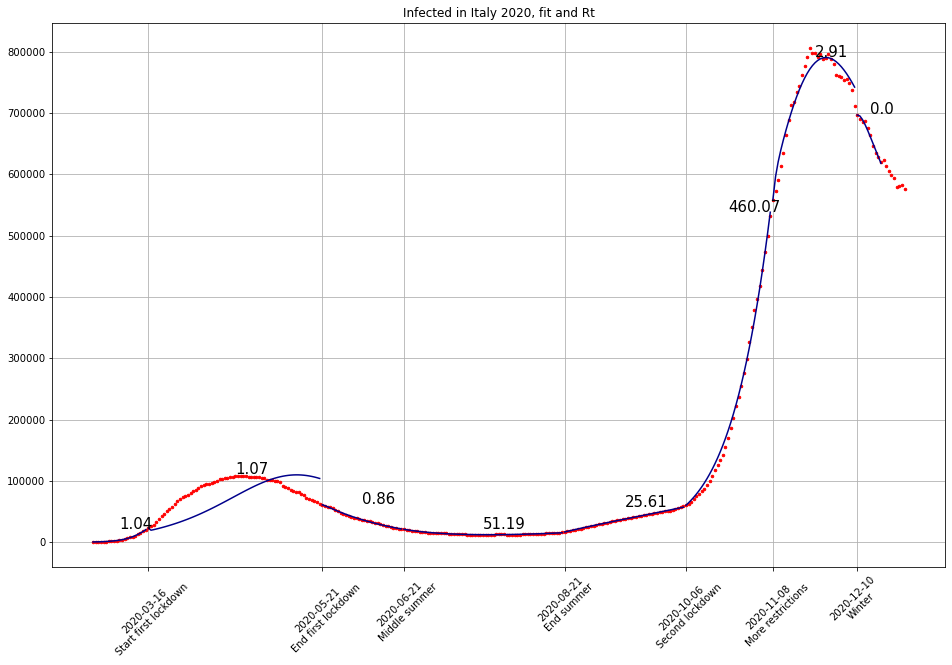

In [11]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, I, 'r.', markersize=5)
for i in range(len(t_list)):
    idx_0 = t_list[i][0]
    idx_1 = t_list[i][1]
    plt.text(xdata[int((idx_1 + idx_0)/2)], np.max(i_list[i]) + 1000, str(round(R_0_list[i],2)), fontsize = 15)
    plt.plot(xdata[idx_0:idx_1], i_list[i], 'darkblue', label = 'SIR model')
plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

# Comparison with R_t diverso

In [569]:
# R_t ISS usando covidstat
Rt_iss = pd.read_csv('data/iss/iss_rt_italia.csv')
Rt_iss = Rt_iss.dropna()
Rt_iss = Rt_iss[(Rt_iss['data'] >= str(xdata[0])) & (Rt_iss['data'] <= str(xdata[len(xdata)-1]))]
Rt_iss = np.array(Rt_iss['rt_positivi'])

In [570]:
# R_t evaluation using Cori et al
R_t_list = []
for t in range(7,len(xdata)):
    R_t(I, t)
    R_t_list.append(R_t(I, t))

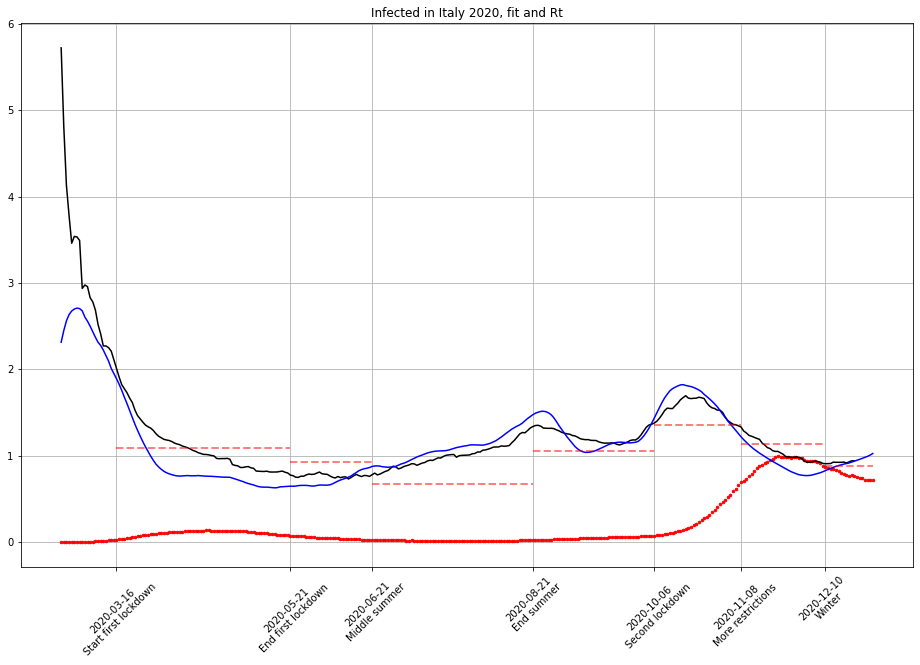

In [571]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, normalized(I), 'r.', markersize=5)
plt.plot(xdata[:-7], R_t_list, 'k', markersize=5)
plt.plot(xdata, Rt_iss, 'b', markersize=5)
plt.hlines(y=1.09, xmin=xdata[21], xmax=xdata[87], linewidth=2, color='r', ls = '--', alpha = 0.5)
plt.hlines(y=0.93, xmin=xdata[87], xmax=xdata[118], linewidth=2, color='r', ls = '--', alpha = 0.5)
plt.hlines(y=0.67, xmin=xdata[118], xmax=xdata[179], linewidth=2, color='r', ls = '--', alpha = 0.5)
plt.hlines(y=1.05, xmin=xdata[179], xmax=xdata[225], linewidth=2, color='r', ls = '--', alpha = 0.5)
plt.hlines(y=1.36, xmin=xdata[225], xmax=xdata[258], linewidth=2, color='r', ls = '--', alpha = 0.5)
plt.hlines(y=1.14, xmin=xdata[258], xmax=xdata[290], linewidth=2, color='r', ls = '--', alpha = 0.5)
plt.hlines(y=0.88, xmin=xdata[290], xmax=xdata[308], linewidth=2, color='r', ls = '--', alpha = 0.5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

# Correlation index between I and R_t_ISS for each temporal lapse

A questo punto ho due indici R_t, uno di ISS e uno di coli et al. Ho anche il numero di infetti I. Facciamo correlazione tra queste 3 variabili e la mobilità.

In [572]:
xdata_covid = xdata 

In [573]:
df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
df = df[df['sub_region_1'].isnull()]
#df = df[df['sub_region_2'].isnull()]
df = df[(df['date'] > '2020-02-23') & (df['date'] < '2020-12-29')]

#df = df[(df['date'] < '2020-12-29')]
df = df.drop(columns=['country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])
df['date'] = pd.to_datetime(df['date'])
df = df.reset_index()
xdata = df['date'].dt.date
df = df.drop(columns=['index', 'sub_region_1'])
print(f'Start: {xdata[0]}')
print(f'End: {xdata[len(xdata)-1]}')
df.head()

Start: 2020-02-24
End: 2020-12-28


,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-24,-4.0,23.0,22.0,-15.0,-14.0,4.0
1,2020-02-25,-6.0,5.0,20.0,-18.0,-15.0,5.0
2,2020-02-26,-13.0,-5.0,-6.0,-23.0,-12.0,6.0
3,2020-02-27,-10.0,-3.0,-1.0,-22.0,-12.0,6.0
4,2020-02-28,-8.0,-2.0,11.0,-20.0,-12.0,5.0


In [574]:
freq = '1D'
ydata = df.groupby(pd.Grouper(key='date', axis=0, freq=freq))['retail_and_recreation_percent_change_from_baseline'].mean()
data_index = ydata.index
days = [xdata_covid[21], xdata_covid[87], xdata_covid[118], xdata_covid[179], xdata_covid[225], xdata_covid[258], xdata_covid[290]]

# scaler = StandardScaler()
# R_t_list = scaler.fit_transform(np.array(R_t_list).reshape(-1, 1))
# R_t_list = scaler.fit_transform(np.array(R_t_list).reshape(-1, 1))

# Correlazione I e mobility

In [ ]:
ydata = normalized(ydata)
I = normalized(I)

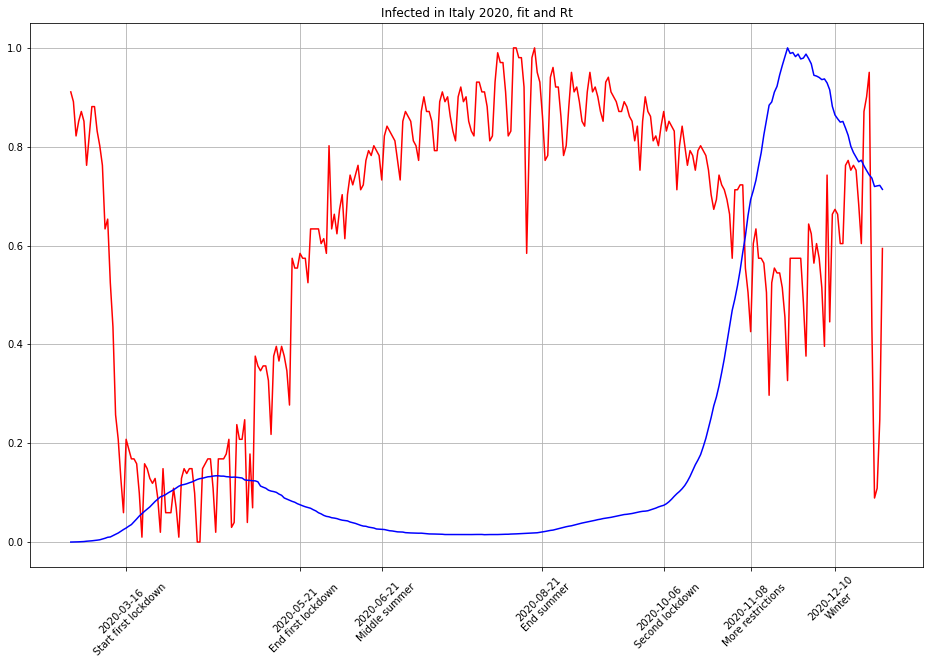

In [327]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5)
plt.plot(xdata, I, 'b', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

Facciamo la correlazione

In [326]:
print(stats.spearmanr(ydata, I))

SpearmanrResult(correlation=-0.5671650042946512, pvalue=1.0641093744747354e-27)


Togliamo gli outlier della mobility via mediana o media e rifacciamo la correlazione

In [364]:
rolling_median = ydata.rolling(window=7).median()
rolling_std = ydata.rolling(window=7).std()
diff = ydata - rolling_median

In [365]:
to_drop = []
for i in range(len(ydata)):
    if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
        to_drop.append(i)

In [366]:
# dobbiamo droppare degli elementi
ydata_new = np.array(ydata)
rolling_median_new = np.array(rolling_median)
xdata_new = np.array(xdata)
I_new = np.array(I)

ydata_new = np.delete(ydata_new, to_drop)
rolling_median_new = np.delete(rolling_median_new, to_drop)
xdata_new = np.delete(xdata_new, to_drop)
I_new = np.delete(I_new, to_drop)

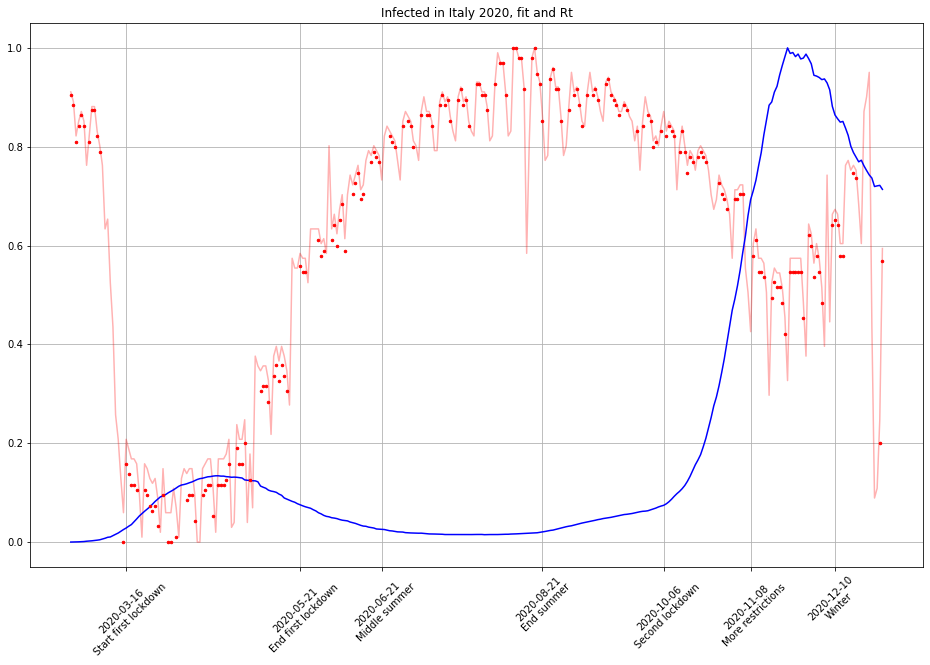

In [367]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5, alpha = 0.3)
plt.plot(xdata, I, 'b', markersize=5)

plt.plot(xdata_new, ydata_new, 'r.', markersize=5)
#plt.plot(xdata_new, normalized(I_new), 'b.', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

New correlation

In [368]:
print(stats.spearmanr(ydata_new, I_new))

SpearmanrResult(correlation=-0.6502044431438615, pvalue=2.0461844383829948e-25)


è un po' più alta, ci sta.

Proviamo ora a fare la correlazione cross


In [378]:
import statsmodels.api as sm
# questa è la pearson cross, non ha senso in questo caso
np.min(sm.tsa.stattools.ccf(ydata, I, adjusted=False))

-0.16196931159216435

Proviamo a fare sta cross correlation

In [417]:
def shift(xs, n):
    if n > 0:
        return np.r_[np.full(n, np.nan), xs[:-n]]
    elif n==0:
        return xs
    else:
        return np.r_[xs[-n:], np.full(-n, np.nan)]

In [437]:
correlations = []

# Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
# questi sono per i -20 a 0
for i in range(-20, 1, 1):
    mob_sh = shift(ydata_new, i)
    mob_sh = mob_sh[~np.isnan(mob_sh)]
    correlations.append(stats.spearmanr(mob_sh, I_new[:len(mob_sh)])[0])

# questo per 0, 20
for i in range(0, 21, 1):
    i_sh = shift(I_new, -i)
    i_sh = i_sh[~np.isnan(i_sh)]
    #print(mob)
    correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])

In [443]:
print('Max correlation: ',np.min(correlations))
print('Shift in days: ',np.arange(-20,21)[np.argmin(correlations)])

Max correlation:  -0.6510689501496927
Shift in days:  2


# Facciamo lo stesso con R_t ISS

In [493]:
ydata = normalized(ydata)
Rt_iss = normalized(Rt_iss)

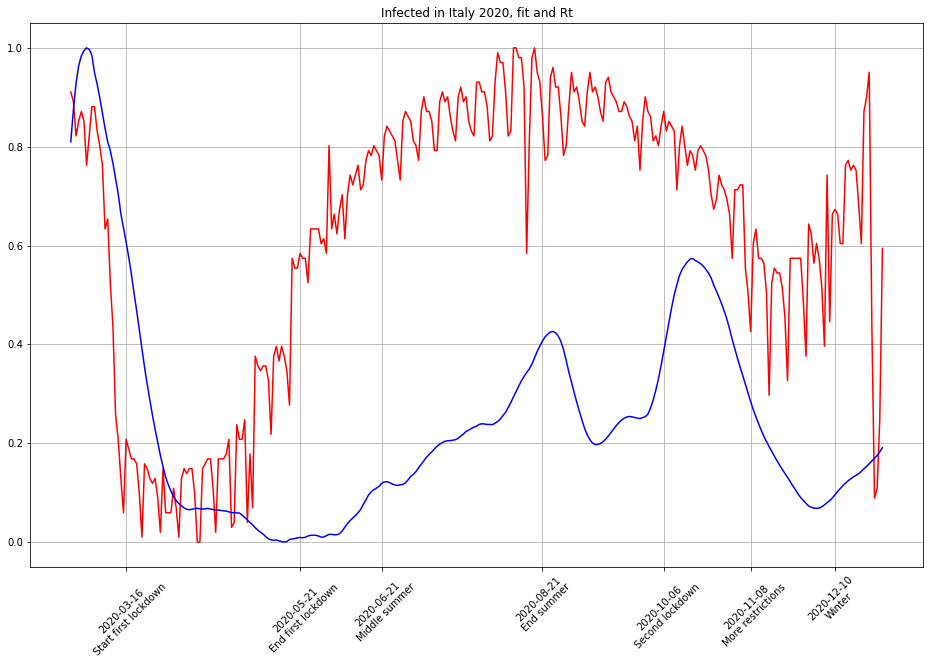

In [494]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5)
plt.plot(xdata, Rt_iss, 'b', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

Facciamo la correlazione

In [495]:
print(stats.spearmanr(ydata, Rt_iss))

SpearmanrResult(correlation=0.42794469354894993, pvalue=3.4316612940462238e-15)


Ci sta, la correlazione deve essere positiva, però si vede un ritardo

Togliamo gli outlier della mobility via mediana o media e rifacciamo la correlazione

In [496]:
rolling_median = ydata.rolling(window=7).median()
rolling_std = ydata.rolling(window=7).std()
diff = ydata - rolling_median

In [497]:
to_drop = []
for i in range(len(ydata)):
    if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
        to_drop.append(i)

In [498]:
# dobbiamo droppare degli elementi
ydata_new = np.array(ydata)
rolling_median_new = np.array(rolling_median)
xdata_new = np.array(xdata)
I_new = np.array(Rt_iss)

ydata_new = np.delete(ydata_new, to_drop)
rolling_median_new = np.delete(rolling_median_new, to_drop)
xdata_new = np.delete(xdata_new, to_drop)
I_new = np.delete(I_new, to_drop)

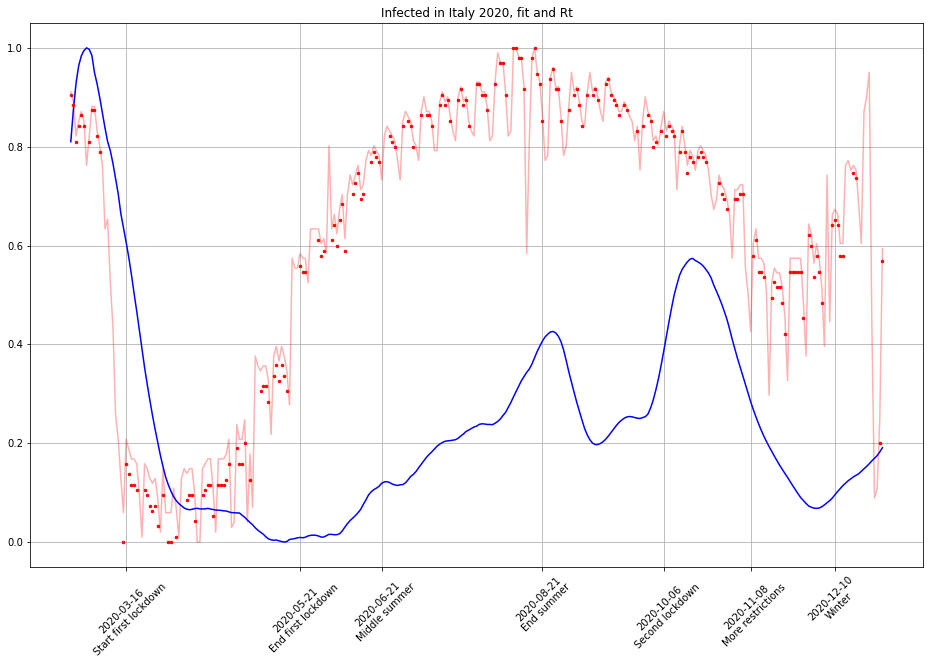

In [499]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5, alpha = 0.3)
plt.plot(xdata, Rt_iss, 'b', markersize=5)

plt.plot(xdata_new, normalized(ydata_new), 'r.', markersize=5)
#plt.plot(xdata_new, normalized(I_new), 'b.', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

New correlation

In [500]:
print(stats.spearmanr(ydata_new, I_new))

SpearmanrResult(correlation=0.4834464295391189, pvalue=4.1323339018332133e-13)


è un po' più alta, ci sta.

Proviamo ora a fare la correlazione cross


In [501]:
import statsmodels.api as sm
# questa è la pearson cross, non ha senso in questo caso
np.max(sm.tsa.stattools.ccf(ydata, Rt_iss, adjusted=False))

0.27010697286543595

Proviamo a fare sta cross correlation

In [502]:
correlations = []

# Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
# questi sono per i -20 a 0
for i in range(-20, 1, 1):
    mob_sh = shift(ydata_new, i)
    mob_sh = mob_sh[~np.isnan(mob_sh)]
    correlations.append(stats.spearmanr(mob_sh, I_new[:len(mob_sh)])[0])

# questo per 0, 20
for i in range(0, 21, 1):
    i_sh = shift(I_new, -i)
    i_sh = i_sh[~np.isnan(i_sh)]
    #print(mob)
    correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])

In [503]:
print('Max correlation: ',np.max(correlations))
print('Shift in days: ',np.arange(-20,21)[np.argmax(correlations)])

Max correlation:  0.8506112672872175
Shift in days:  17


Proviamo a plottare questo shift in days

In [504]:
i_sh = shift(I_new, -17)
i_sh = i_sh[~np.isnan(i_sh)]
#print(mob)
correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])

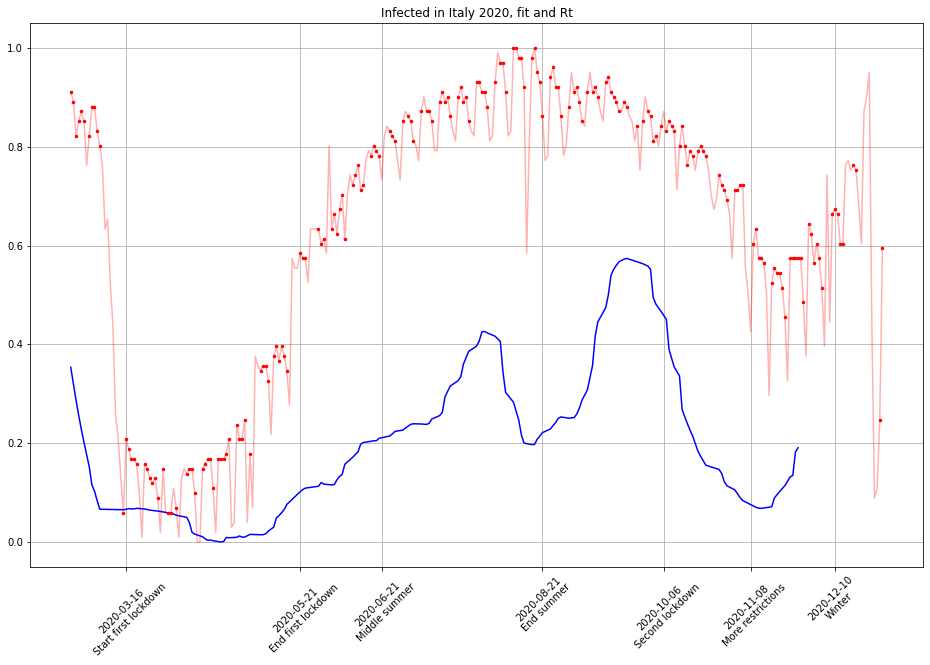

In [505]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5, alpha = 0.3)
plt.plot(xdata_new[:len(i_sh)], i_sh, 'b', markersize=5)

plt.plot(xdata_new, ydata_new, 'r.', markersize=5)
#plt.plot(xdata_new, normalized(I_new), 'b.', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

# Same ma con r_t di coli et al

Cambiato un po' gli array

In [563]:
xdata = xdata[:-7]
ydata = normalized(ydata[:-7])
Rt_iss = normalized(R_t_list)

ValueError: x and y must have same first dimension, but have shapes (295,) and (302,)

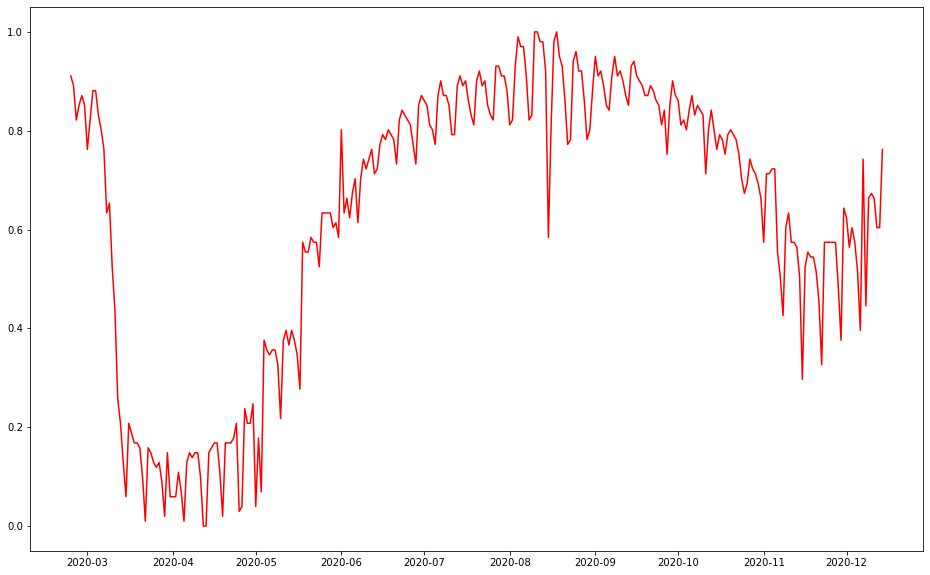

In [564]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5)
plt.plot(xdata, Rt_iss, 'b', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

Facciamo la correlazione

In [517]:
print(stats.spearmanr(ydata, Rt_iss))

SpearmanrResult(correlation=0.10614158077918767, pvalue=0.06546028669197536)


Moolto bassa

Togliamo gli outlier della mobility via mediana o media e rifacciamo la correlazione

In [518]:
rolling_median = ydata.rolling(window=7).median()
rolling_std = ydata.rolling(window=7).std()
diff = ydata - rolling_median

In [519]:
to_drop = []
for i in range(len(ydata)):
    if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
        to_drop.append(i)

In [520]:
# dobbiamo droppare degli elementi
ydata_new = np.array(ydata)
rolling_median_new = np.array(rolling_median)
xdata_new = np.array(xdata)
I_new = np.array(Rt_iss)

ydata_new = np.delete(ydata_new, to_drop)
rolling_median_new = np.delete(rolling_median_new, to_drop)
xdata_new = np.delete(xdata_new, to_drop)
I_new = np.delete(I_new, to_drop)

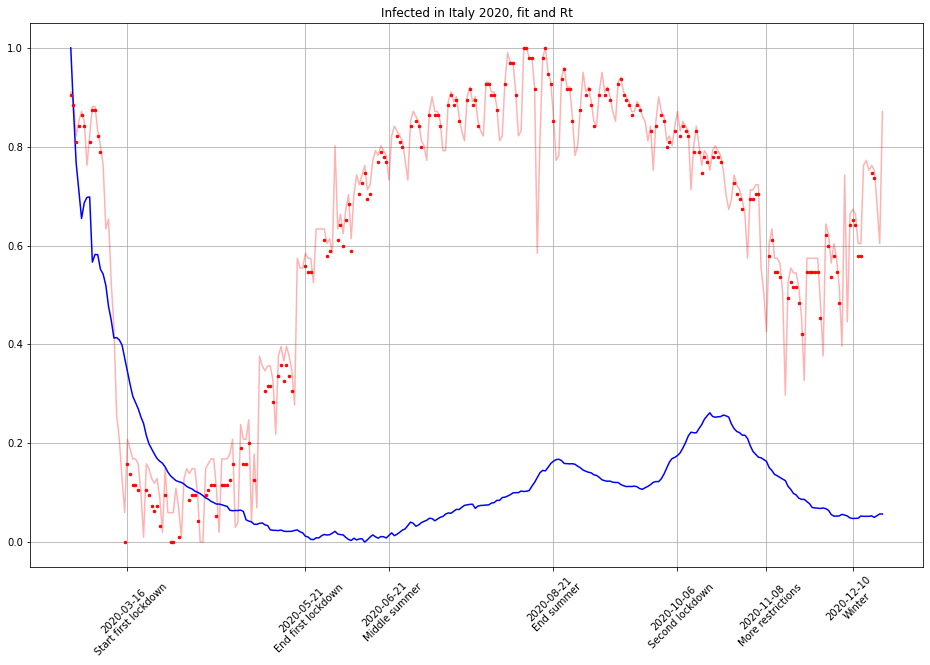

In [521]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5, alpha = 0.3)
plt.plot(xdata, Rt_iss, 'b', markersize=5)

plt.plot(xdata_new, normalized(ydata_new), 'r.', markersize=5)
#plt.plot(xdata_new, normalized(I_new), 'b.', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

New correlation

In [522]:
print(stats.spearmanr(ydata_new, I_new))

SpearmanrResult(correlation=0.16401331808042308, pvalue=0.02094816043453764)


è un po' più alta, ci sta.

Proviamo ora a fare la correlazione cross


In [523]:
import statsmodels.api as sm
# questa è la pearson cross, non ha senso in questo caso
np.max(sm.tsa.stattools.ccf(ydata, Rt_iss, adjusted=False))

0.23895582193176768

Proviamo a fare sta cross correlation

In [536]:
correlations = []

# Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
# questi sono per i -20 a 0
for i in range(-30, 0, 1):
    mob_sh = shift(ydata_new, i)
    mob_sh = mob_sh[~np.isnan(mob_sh)]
    correlations.append(stats.spearmanr(mob_sh, I_new[:len(mob_sh)])[0])

# questo per 0, 20
for i in range(0, 31, 1):
    i_sh = shift(I_new, -i)
    i_sh = i_sh[~np.isnan(i_sh)]
    #print(mob)
    correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])

In [537]:
print('Max correlation: ',np.max(correlations))
print('Shift in days: ', np.arange(-30,31)[np.argmax(correlations)])

Max correlation:  0.8832121137786001
Shift in days:  28


Proviamo a plottare questo shift in days

In [538]:
i_sh = shift(I_new, -20)
i_sh = i_sh[~np.isnan(i_sh)]
#print(mob)
correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])

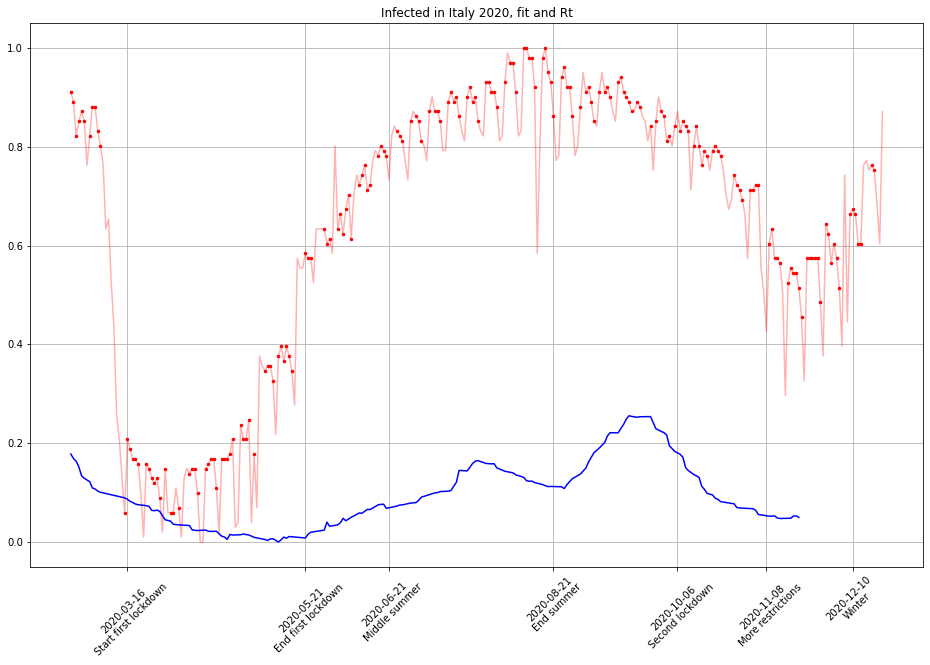

In [539]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, ydata, 'r', markersize=5, alpha = 0.3)
plt.plot(xdata_new[:len(i_sh)], i_sh, 'b', markersize=5)

plt.plot(xdata_new, ydata_new, 'r.', markersize=5)
#plt.plot(xdata_new, normalized(I_new), 'b.', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

Molto peggio dell'altro indice R_t. Non so perché

# Provo ad automatizzare il tutto

In [582]:
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [584]:
for name in names:
    print('\n The category is: ', name)
    df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
    df = df[df['sub_region_1'].isnull()]
    df = df[(df['date'] > '2020-02-23') & (df['date'] < '2020-12-29')]
    df = df.drop(columns=['country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.reset_index()
    xdata = df['date'].dt.date
    df = df.drop(columns=['index', 'sub_region_1'])

    freq = '1D'
    ydata = df.groupby(pd.Grouper(key='date', axis=0, freq=freq))[name].mean()
    data_index = ydata.index
    days = [xdata_covid[21], xdata_covid[87], xdata_covid[118], xdata_covid[179], xdata_covid[225], xdata_covid[258], xdata_covid[290]]

    ydata = normalized(ydata)
    I = normalized(I)
    Rt_iss = normalized(Rt_iss)
    Rt_coli = normalized(R_t_list)

    # Togliere outlier da mobility
    rolling_median = ydata.rolling(window=7).median()
    rolling_std = ydata.rolling(window=7).std()
    diff = ydata - rolling_median

    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)

    ydata_new = np.array(ydata)
    rolling_median_new = np.array(rolling_median)
    xdata_new = np.array(xdata)
    I_new = np.array(I)
    Rt_iss_new = np.array(Rt_iss)
    #Rt_coli_new = np.array(Rt_coli)
    ydata_new = np.delete(ydata_new, to_drop)
    rolling_median_new = np.delete(rolling_median_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    I_new = np.delete(I_new, to_drop)
    Rt_iss_new = np.delete(Rt_iss, to_drop)
    #Rt_coli_new = np.delete(Rt_coli_new, to_drop)

    # Mobility e I
    print('I Senza niente: ',stats.spearmanr(ydata, I)[0])
    print('I Median mobility: ', stats.spearmanr(ydata_new, I_new)[0])
    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-30, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, I_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 31, 1):
        i_sh = shift(I_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)
    if np.abs(mi) > ma:
        print('I cross correlation: ',np.min(correlations))
        print('I shift in days: ',np.arange(-30,31)[np.argmin(correlations)])
    else:
        print('I cross correlation: ',np.max(correlations))
        print('I shift in days: ',np.arange(-30,31)[np.argmax(correlations)])


    # Mobility e Rt_ISS
    print('Rt_ISS Senza niente: ',stats.spearmanr(ydata, Rt_iss)[0])
    print('Rt_ISS Median mobility: ', stats.spearmanr(ydata_new, Rt_iss_new)[0])
    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-30, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 31, 1):
        i_sh = shift(Rt_iss_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)
    if np.abs(mi) > ma:
        print('Rt_ISS cross correlation: ',np.min(correlations))
        print('Rt_ISS shift in days: ',np.arange(-30,31)[np.argmin(correlations)])
    else:
        print('Rt_ISS cross correlation: ',np.max(correlations))
        print('Rt_ISS shift in days: ',np.arange(-30,31)[np.argmax(correlations)])

    # Mobility e Rt_coli
    xdata = xdata[:-7]
    ydata = ydata[:-7]
    rolling_median = ydata.rolling(window=7).median()
    rolling_std = ydata.rolling(window=7).std()
    diff = ydata - rolling_median
    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)
    ydata_new = np.array(ydata)
    rolling_median_new = np.array(rolling_median)
    xdata_new = np.array(xdata)
    Rt_coli_new = np.array(Rt_coli)
    ydata_new = np.delete(ydata_new, to_drop)
    rolling_median_new = np.delete(rolling_median_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    Rt_coli_new = np.delete(Rt_coli_new, to_drop)
    print('Rt_coli Senza niente: ',stats.spearmanr(ydata, Rt_coli)[0])
    print('Rt_coli Median mobility: ', stats.spearmanr(ydata_new, Rt_coli_new)[0])
    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-30, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, Rt_coli_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 31, 1):
        i_sh = shift(Rt_coli_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)
    if np.abs(mi) > ma:
        print('Rt_coli cross correlation: ',np.min(correlations))
        print('Rt_coli shift in days: ',np.arange(-30,31)[np.argmin(correlations)])
    else:
        print('Rt_coli cross correlation: ',np.max(correlations))
        print('Rt_coli shift in days: ',np.arange(-30,31)[np.argmax(correlations)])


 The category is:  retail_and_recreation_percent_change_from_baseline
I Senza niente:  -0.5671650042946512
I Median mobility:  -0.6502044431438615
I cross correlation:  -0.6510689501496927
I shift in days:  1
Rt_ISS Senza niente:  0.42794469354894993
Rt_ISS Median mobility:  0.4834464295391189
I cross correlation:  0.8506112672872175
I shift in days:  16
Rt_coli Senza niente:  0.10669609806476596
Rt_coli Median mobility:  0.16401563778715603
I cross correlation:  0.8831058179411012
I shift in days:  28

 The category is:  grocery_and_pharmacy_percent_change_from_baseline
I Senza niente:  -0.15758474325675115
I Median mobility:  -0.1738714460199376
I cross correlation:  0.4476880239356291
I shift in days:  30
Rt_ISS Senza niente:  0.47100495923482405
Rt_ISS Median mobility:  0.6066553794128078
I cross correlation:  0.8397019242448873
I shift in days:  11
Rt_coli Senza niente:  0.25853270026061
Rt_coli Median mobility:  0.3760901975167428
I cross correlation:  0.7418586616820099
I shift

Non ha molto senso, l'indice r_t sembra essere in ritardo rispetto ai contagi

In [15]:
s = 0
e = 87
#print(stats.spearmanr(R_t_list[s:e-7],Rt_iss[s+7:e])[0])
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
#print(stats.spearmanr(I[s+7:e], R_t_list[s:e-7])[0])
s = 21
e = 87
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
s = 87
e = 118
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
s = 118
e = 179
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
s = 179
e = 225
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
s = 225
e = 258
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
s = 258
e = 290
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])
s = 290
e = -1
print(stats.spearmanr(I[s:e], Rt_iss[s:e])[0])

-0.7025588685572647
-0.3270848554430645
-0.9713709677419355
-0.36003067253919774
-0.36318223866790006
-0.5060160427807487
-0.5597507331378299
-0.9876160990712075


Proviamo ad aggiungere un ritardo

In [19]:
delay = -30
# s = 0
# e = 21
# #print(stats.spearmanr(R_t_list[s:e-7],Rt_iss[s+7:e])[0])
# print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
# #print(stats.spearmanr(I[s+7:e], R_t_list[s:e-7])[0])
s = 30
e = 87
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
s = 87
e = 118
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
s = 118
e = 179
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
s = 179
e = 225
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
s = 225
e = 258
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
s = 258
e = 290
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])
s = 290
e = -1
print(stats.spearmanr(I[s:e], Rt_iss[s+delay:e+delay])[0])

0.05956702100077781
0.8923387096774194
-0.38033792551438156
0.7615787850755472
0.938168449197861
-0.1348973607038123
0.9876160990712075


# Adesso correlazione tra movimenti e r_t

In [9]:
xdata_covid = xdata 

In [198]:
df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
df = df[df['sub_region_1'].isnull()]
#df = df[df['sub_region_2'].isnull()]
df = df[(df['date'] > '2020-02-23') & (df['date'] < '2020-12-29')]

#df = df[(df['date'] < '2020-12-29')]
df = df.drop(columns=['country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])
df['date'] = pd.to_datetime(df['date'])
df = df.reset_index()
xdata = df['date'].dt.date
df = df.drop(columns=['index', 'sub_region_1'])
print(f'Start: {xdata[0]}')
print(f'End: {xdata[len(xdata)-1]}')
df.head()

Start: 2020-02-24
End: 2020-12-28


,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-24,-4.0,23.0,22.0,-15.0,-14.0,4.0
1,2020-02-25,-6.0,5.0,20.0,-18.0,-15.0,5.0
2,2020-02-26,-13.0,-5.0,-6.0,-23.0,-12.0,6.0
3,2020-02-27,-10.0,-3.0,-1.0,-22.0,-12.0,6.0
4,2020-02-28,-8.0,-2.0,11.0,-20.0,-12.0,5.0


In [128]:
# freq = '1D'
# ydata = df.groupby(pd.Grouper(key='date', axis=0, freq=freq))['retail_and_recreation_percent_change_from_baseline'].mean()
# data_index = ydata.index # index for rt
# days = [xdata_covid[21], xdata_covid[87], xdata_covid[118], xdata_covid[179], xdata_covid[225], xdata_covid[258], xdata_covid[290]] # important days

In [129]:
#ydata_percentual_change, xdata_percentual_change = percentual_change(ydata, media = 4)
#xdata_percentual_change = [data_index[i] for i in xdata_percentual_change]

In [130]:
# scaler = StandardScaler()
# ydata_percentual_change = scaler.fit_transform(np.array(ydata_percentual_change).reshape(-1, 1))
# R_0 = scaler.fit_transform(np.array(R_0_list).reshape(-1, 1))

In [131]:
# import scipy.stats as stats
# t = []
# for k in range(0,len(I), 28):
#     tau, p_value = stats.kendalltau(I[k:k+28], ydata[9+k:9+k+28])
#     t.append(tau)

In [132]:
# t = [stats.kendalltau(I[k:k+28], ydata[9+k:9+k+28])[0] for k in range(0,len(I),28)]
# t

In [133]:
# plt.figure(figsize=(16, 10))
# plt.plot(data_index, ydata, 'darkblue')
# plt.plot(xdata_covid, normalized(I), 'darkred', markersize=5)

# #plt.plot(xdata_percentual_change, ydata_percentual_change*50, 'blue', ls = '--', alpha = 0.5)
# #plt.plot(days, R_0_list, 'red')
# for r in range(len(R_0)-1):
#     if r == 0:
#         plt.hlines(y=R_0[r]*100, xmin=xdata_percentual_change[0], xmax=days[r], linewidth=2, color='r', ls = '--', alpha = 0.5)
#     else:
#         plt.hlines(y=R_0[r]*100, xmin=days[r-1], xmax=days[r], linewidth=2, color='r', ls = '--', alpha = 0.5)

# # for d in days:
# #     plt.axvline(d, color = 'k',alpha = 0.5, ls = '-',label =str(d))

# for i in range(len(t_list)):
#     idx_0 = t_list[i][0]
#     idx_1 = t_list[i][1]
#     #plt.hlines(y=round(R_0_list[i],2), xmin=xdata[idx_0], xmax=xdata[idx_1], color='k', linestyle='-')
#     plt.text(xdata[int((idx_1 + idx_0)/2)], 50, str(round(R_0_list[i],2)), fontsize = 15)
    
# plt.legend(["Occupation percentage", 'Infected'],prop={"size":10})
# plt.xlabel("date",size=21)
# plt.ylabel("percentage",size=21)
# plt.title("retail_and_recreation_percent_change_from_baseline")
# plt.xticks(days,labels=[str(xdata_covid[21]) +'\n'+ 'Start first lockdown',
#             str(xdata_covid[87]) +'\n'+ 'End first lockdown',
#             str(xdata_covid[118]) +'\n'+ 'Middle summer',
#             str(xdata_covid[179]) +'\n'+ 'End summer',
#             str(xdata_covid[225]) +'\n'+ 'Second lockdown',
#             str(xdata_covid[258]) +'\n'+ 'More restrictions',
#             str(xdata_covid[290]) +'\n'+ 'Winter'], rotation = 45, fontsize=10) 
# plt.yticks(fontsize=10) 
# plt.grid()
# plt.show()

In [134]:
tau_list = []
freq = '1D'
ydata = df.groupby(pd.Grouper(key='date', axis=0, freq=freq))['retail_and_recreation_percent_change_from_baseline'].mean()
data_index = ydata.index
days = [xdata_covid[21], xdata_covid[87], xdata_covid[118], xdata_covid[179], xdata_covid[225], xdata_covid[258], xdata_covid[290]]

scaler = StandardScaler()
R_t_list = scaler.fit_transform(np.array(R_t_list).reshape(-1, 1))

NameError: name 'R_t_list' is not defined

In [19]:
stats.spearmanr(ydata, Rt_iss)

SpearmanrResult(correlation=0.42794469354894993, pvalue=3.4316612940462238e-15)

In [31]:
s = 0
e = 21
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 21
e = 87
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 87
e = 118
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 118
e = 179
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 179
e = 225
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 225
e = 258
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 258
e = 290
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])
s = 290
e = -1
print(stats.spearmanr(ydata[s:e], Rt_iss[s:e])[0])

0.692458322799961
-0.6383291678688411
0.8822199480585008
0.587961841600195
-0.19819585190924263
0.39980003382834567
-0.1467158614735867
-0.2339555795629525


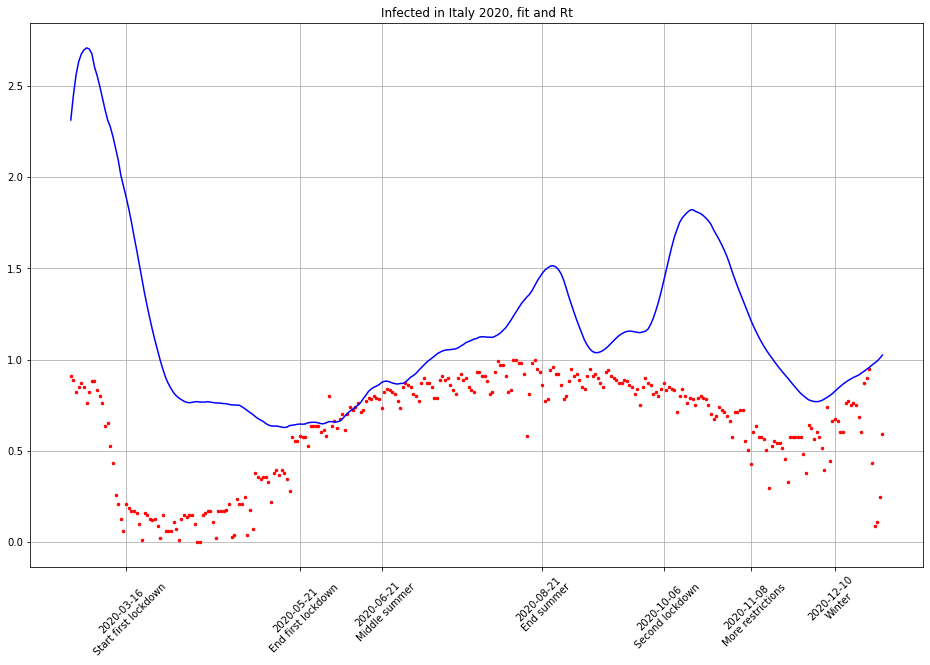

In [32]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, normalized(ydata), 'r.', markersize=5)

plt.plot(xdata, Rt_iss, 'b', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

Ci sta, proviamo la correlazione tra mobilità ed infetti

In [20]:
stats.spearmanr(ydata, I)

SpearmanrResult(correlation=-0.5671650042946512, pvalue=1.0641093744747354e-27)

In [21]:
stats.kendalltau(ydata, I)

KendalltauResult(correlation=-0.38069861511235453, pvalue=3.7623274385297425e-23)

In [22]:
stats.pearsonr(ydata, I)

(-0.1619693115921643, 0.004310555698588878)

In [33]:
s = 0
e = 21
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 21
e = 87
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 87
e = 118
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 118
e = 179
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 179
e = 225
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 225
e = 258
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 258
e = 290
print(stats.spearmanr(ydata[s:e], I[s:e])[0])
s = 290
e = -1
print(stats.spearmanr(ydata[s:e], I[s:e])[0])

-0.8920683745366634
-0.13971877257213655
-0.8419811743560847
-0.2485834500272753
-0.2968920712728412
-0.8347730911606513
-0.09035775347680591
0.2339555795629525


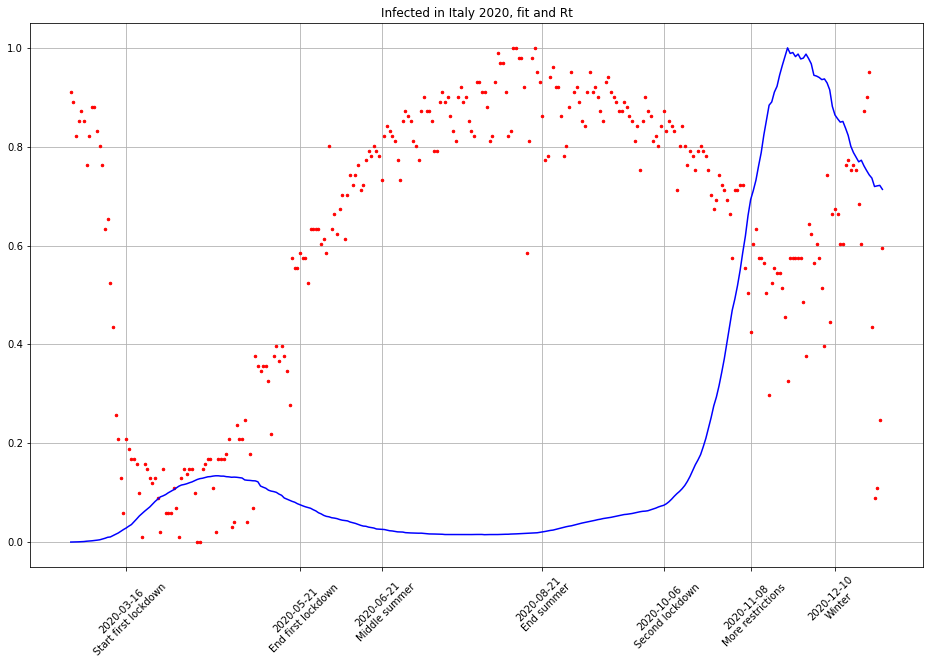

In [34]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, normalized(ydata), 'r.', markersize=5)

plt.plot(xdata, normalized(I), 'b', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 45,
    fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

In [30]:
stats.spearmanr(ydata[0:179], I[0:179])

SpearmanrResult(correlation=-0.7981661625697533, pvalue=8.284787337916484e-41)

In [33]:
stats.spearmanr(ydata[179:290], I[179:290])

SpearmanrResult(correlation=-0.8856651616998382, pvalue=4.1442353444300655e-38)

In [26]:
stats.spearmanr(ydata[225:], I[225:])

SpearmanrResult(correlation=-0.6521477841661203, pvalue=1.8189528386007238e-11)

# RIMUOVI GLI OUTLIER ROSSI

In [297]:
ydata = df.groupby(pd.Grouper(key='date', axis=0, freq=freq))['retail_and_recreation_percent_change_from_baseline'].mean()
xdata = df['date'].dt.date

In [298]:
# window_size = 3
# numbers_series = pd.Series(ydata)
# windows = numbers_series.rolling(window_size)
# moving_averages = windows.median()
# moving_averages_list = moving_averages.tolist()
# final_list = moving_averages_list[window_size - 1:]

# moving_std = windows.std()
# moving_std_list = moving_std.tolist()
# final_list_std = moving_std_list[window_size - 1:]
# #print(final_list)

In [299]:
rolling_median = ydata.rolling(window=7).median()
rolling_std = ydata.rolling(window=7).std()
diff = ydata - rolling_median

In [300]:
to_drop = []
for i in range(len(ydata)):
    if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
        to_drop.append(i)

In [301]:
len(to_drop)

109

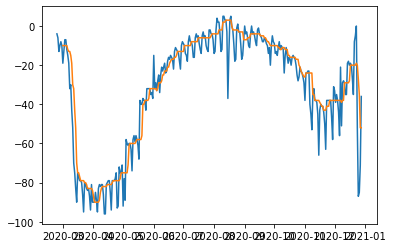

In [302]:
plt.plot(xdata, ydata)
plt.plot(xdata, rolling_median)

In [ ]:
ydata = np.array(ydata)
rolling_median = np.array(rolling_median)
xdata = np.array(xdata)
I = np.array(I)

In [ ]:
ydata = np.delete(ydata, to_drop)
rolling_median = np.delete(rolling_median, to_drop)
xdata = np.delete(xdata, to_drop)
I = np.delete(I, to_drop)

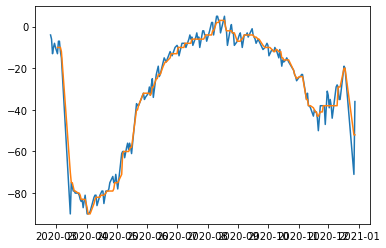

In [305]:
plt.plot(xdata, ydata)
plt.plot(xdata, rolling_median)

In [306]:
stats.spearmanr(ydata[0:179], I[0:179])

SpearmanrResult(correlation=-0.6643388311602362, pvalue=3.750362101811065e-24)

In [307]:
stats.spearmanr(ydata[179:290], I[179:290])

SpearmanrResult(correlation=-0.38292788646658554, pvalue=0.08664673127169367)

In [308]:
stats.spearmanr(ydata[225:], I[225:])

SpearmanrResult(correlation=nan, pvalue=nan)

In [309]:
stats.spearmanr(ydata, I)

SpearmanrResult(correlation=-0.6502044431438615, pvalue=2.0461844383829948e-25)

In [310]:
stats.kendalltau(ydata, I)

KendalltauResult(correlation=-0.4389241918699183, pvalue=5.602971444191739e-20)

In [311]:
stats.pearsonr(ydata, I)

(-0.17914925489234584, 0.011141119792877753)

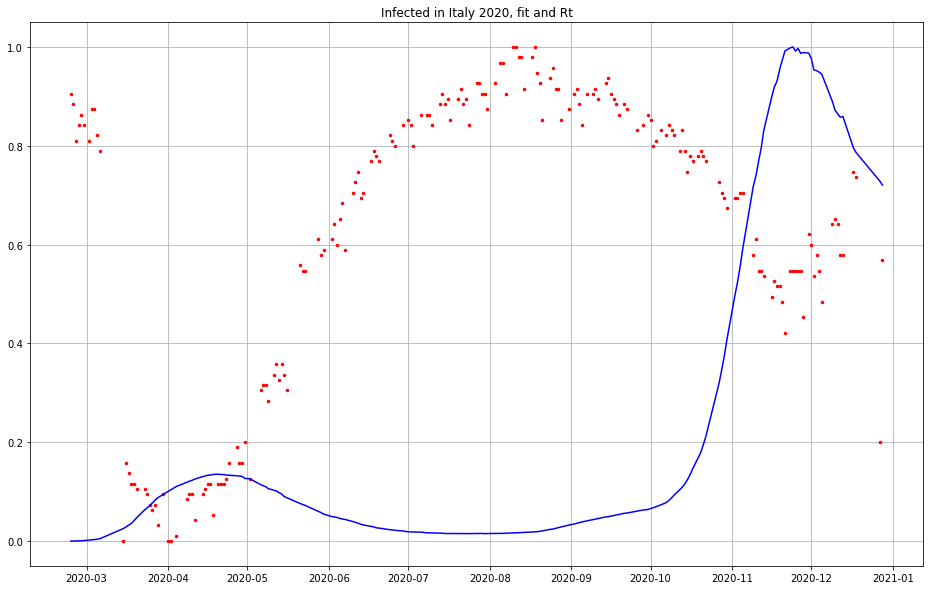

In [313]:
plt.figure(figsize=(16, 10))

plt.plot(xdata, normalized(ydata), 'r.', markersize=5)

plt.plot(xdata, normalized(I), 'b', markersize=5)

plt.title('Infected in Italy 2020, fit and Rt')

plt.yticks(fontsize=10)
plt.grid()
plt.show()

In [61]:
name = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
def plots(R_t_list):
    tau_list = []
    i = 0
    j = 0
    fig, ax = plt.subplots(3, 2,figsize=(20, 20))
    for n in range(len(name)):
        freq = '3D'
        # Data of each category in group of freq-days
        ydata = df.groupby(pd.Grouper(key='date', axis=0, freq=freq))[name[n]].mean()
        # Dates
        data_index = ydata.index # index for rt
        days = [xdata_covid[21], xdata_covid[87], xdata_covid[118], xdata_covid[179], xdata_covid[225], xdata_covid[258], xdata_covid[290]] # important days
        
        scaler = StandardScaler()
        R_t_list = scaler.fit_transform(np.array(R_t_list).reshape(-1, 1))
        tau = [stats.kendalltau(I[k:k+28], ydata[9+k:9+k+28])[0] for k in range(0,len(I),28)]
        tau_list.append(tau)
        
        
        ax[i,j].plot(data_index, normalized(ydata), 'darkblue')
        ax[i,j].plot(xdata_covid, normalized(I, factor = 1), 'darkred', markersize=5)
        ax[i,j].plot(xdata_covid[7:], R_0, 'k', markersize=5)
        
        # for r in range(len(R_0)-1):
        #     if r == 0:
        #         ax[i,j].hlines(y=R_0[r]*100, xmin=xdata_covid[0], xmax=days[r], linewidth=2, color='r', ls = '--', alpha = 0.5)
        #     else:
        #         ax[i,j].hlines(y=R_0[r]*100, xmin=days[r-1], xmax=days[r], linewidth=2, color='r', ls = '--', alpha = 0.5)

        # for k in range(len(t_list)):
        #     idx_0 = t_list[k][0]
        #     idx_1 = t_list[k][1]
        #     ax[i,j].text(xdata[int((idx_1 + idx_0)/2)], R_0[k]*100 + 5, str(round(R_0_list[k],2)), fontsize = 15)

        ax[i,j].legend(["Occupation percentage", 'Infected', 'R_t'],prop={"size":10})
        ax[i,j].set_xlabel("date",size=15)
        ax[i,j].set_ylabel("percentage",size=15)
        ax[i,j].set_title(name[n], fontsize = 15)
        ax[i,j].set_xticks(days,labels=[str(xdata_covid[21]) +'\n'+ 'Start first lockdown',
                    str(xdata_covid[87]) +'\n'+ 'End first lockdown',
                    str(xdata_covid[118]) +'\n'+ 'Middle summer',
                    str(xdata_covid[179]) +'\n'+ 'End summer',
                    str(xdata_covid[225]) +'\n'+ 'Second lockdown',
                    str(xdata_covid[258]) +'\n'+ 'More restrictions',
                    str(xdata_covid[290]) +'\n'+ 'Winter'], rotation = 45, fontsize=10) 
        #ax[i,j].set_yticks(fontsize=10) 
        ax[i,j].grid()
        if (j == 1):
            i += 1
            j = 0
        else:
            j += 1
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.0, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    return tau_list

ValueError: All inputs to `kendalltau` must be of the same size, found x-size 28 and y-size 13

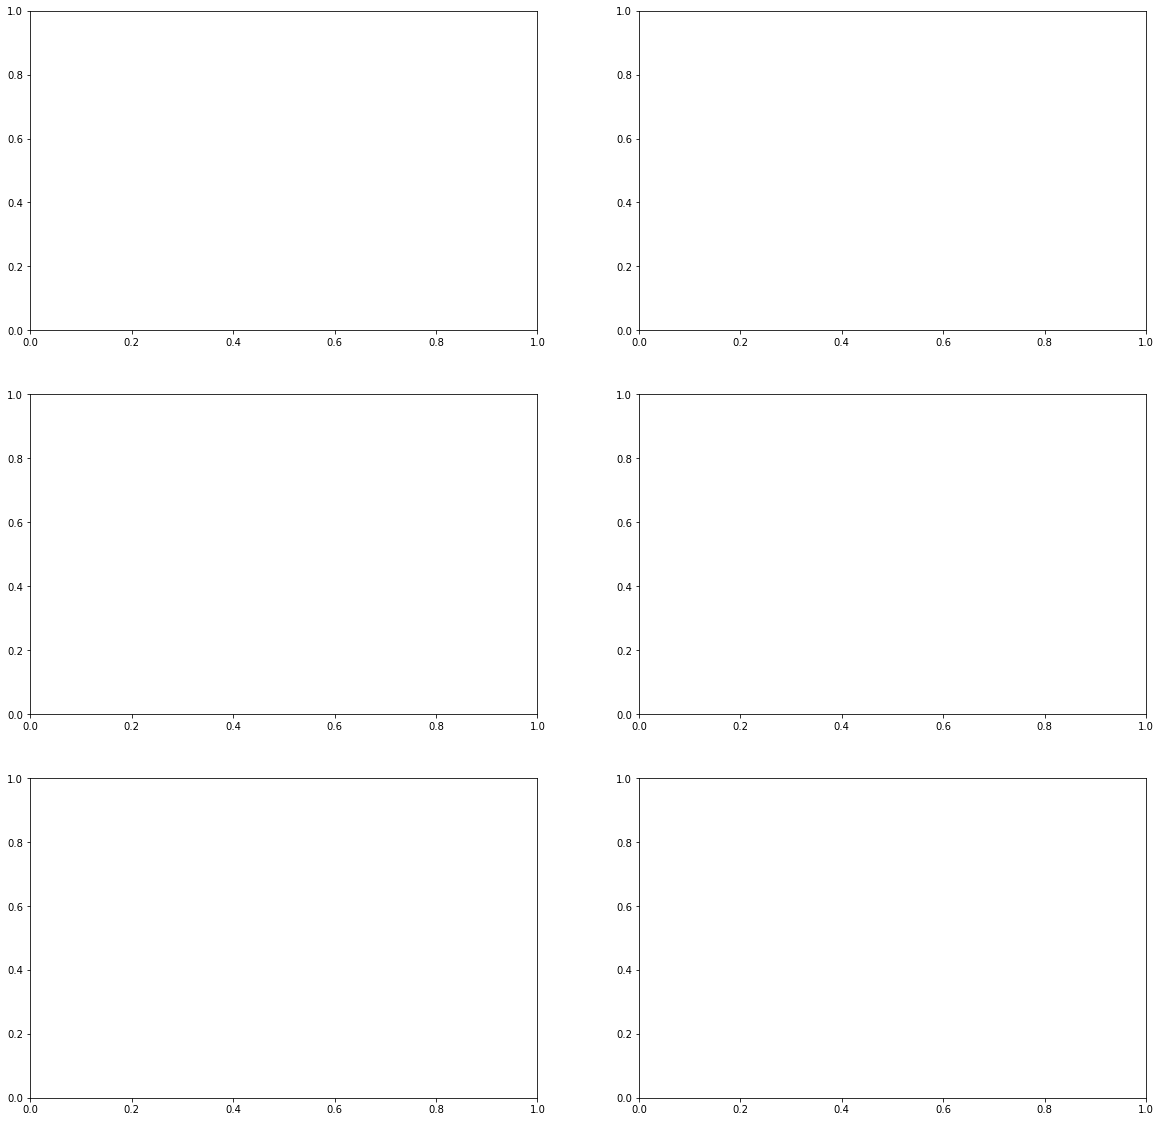

In [62]:
tau_list = plots(R_t_list)